# MBML 2023

## INIT

### Load Packages

In [50]:
import pandas as pd
import kaggle
import os
import shutil
import requests
import urllib
from urllib.request import urlopen, urlretrieve
from io import BytesIO
from zipfile import ZipFile
import matplotlib.pyplot as plt
import plotly.express as px


from src.data import extract, load, transform

### Set Flags

In [8]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)  

DATA_DIR = "data/"

## Data

### Extract Data

In [ ]:
# Download Fligt Delay Dataset form Kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    "robikscube/flight-delay-dataset-20182022",
    path=DATA_DIR,
    unzip=True,
)
for filename in os.listdir(DATA_DIR):
    f = os.path.join(DATA_DIR, filename)
    if f.endswith(".parquet") or filename == "Airlines.csv":
        pass
    else:
        if os.path.isfile(f):
            os.remove(f)
        else:
            shutil.rmtree(f)

In [ ]:
# Download Location of airports
urlretrieve(
    "https://raw.githubusercontent.com/lxndrblz/Airports/main/airports.csv", 
    DATA_DIR + "airports.csv"
    )

### Transform Data

### Load Data

In [68]:
main_df = extract.combine_parquet(data_path = "data/")
main_df['count'] = 1
airport_df = pd.read_csv('data/airports.csv')
airline_df = pd.read_csv('data/Airlines.csv')

### Describe Data

In [70]:
main_df.head()

,FlightDate,Airline,Origin,Dest,Cancelled,Diverted,CRSDepTime,DepTime,DepDelayMinutes,DepDelay,ArrTime,ArrDelayMinutes,AirTime,CRSElapsedTime,ActualElapsedTime,Distance,Year,Quarter,Month,DayofMonth,DayOfWeek,Marketing_Airline_Network,Operated_or_Branded_Code_Share_Partners,DOT_ID_Marketing_Airline,IATA_Code_Marketing_Airline,Flight_Number_Marketing_Airline,Operating_Airline,DOT_ID_Operating_Airline,IATA_Code_Operating_Airline,Tail_Number,Flight_Number_Operating_Airline,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepDel15,DepartureDelayGroups,DepTimeBlk,TaxiOut,WheelsOff,WheelsOn,TaxiIn,CRSArrTime,ArrDelay,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,DistanceGroup,DivAirportLandings,count
0,2018-01-23,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1256.0,0.0,38.0,62.0,59.0,145.0,2018,1,1,23,2,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8928A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,14.0,1211.0,1249.0,7.0,1304,-8.0,0.0,-1.0,1300-1359,1,0.0,1
1,2018-01-24,Endeavor Air Inc.,ABY,ATL,False,False,1202,1157.0,0.0,-5.0,1258.0,0.0,36.0,62.0,61.0,145.0,2018,1,1,24,3,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,13.0,1210.0,1246.0,12.0,1304,-6.0,0.0,-1.0,1300-1359,1,0.0,1
2,2018-01-25,Endeavor Air Inc.,ABY,ATL,False,False,1202,1153.0,0.0,-9.0,1302.0,0.0,40.0,62.0,69.0,145.0,2018,1,1,25,4,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8836A,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,18.0,1211.0,1251.0,11.0,1304,-2.0,0.0,-1.0,1300-1359,1,0.0,1
3,2018-01-26,Endeavor Air Inc.,ABY,ATL,False,False,1202,1150.0,0.0,-12.0,1253.0,0.0,35.0,62.0,63.0,145.0,2018,1,1,26,5,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N800AY,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1200-1259,17.0,1207.0,1242.0,11.0,1304,-11.0,0.0,-1.0,1300-1359,1,0.0,1
4,2018-01-27,Endeavor Air Inc.,ABY,ATL,False,False,1400,1355.0,0.0,-5.0,1459.0,0.0,36.0,60.0,64.0,145.0,2018,1,1,27,6,DL,DL_CODESHARE,19790,DL,3298,9E,20363,9E,N8839E,3298,10146,1014602,30146,"Albany, GA",GA,13,Georgia,34,10397,1039707,30397,"Atlanta, GA",GA,13,Georgia,34,0.0,-1.0,1400-1459,17.0,1412.0,1448.0,11.0,1500,-1.0,0.0,-1.0,1500-1559,1,0.0,1


C:\Users\OliverSvaneOlsen\AppData\Local\Temp\ipykernel_19452\3539999081.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  g_main_df = main_df.groupby(["Year","Month","DistanceGroup"]).sum().unstack().reset_index()


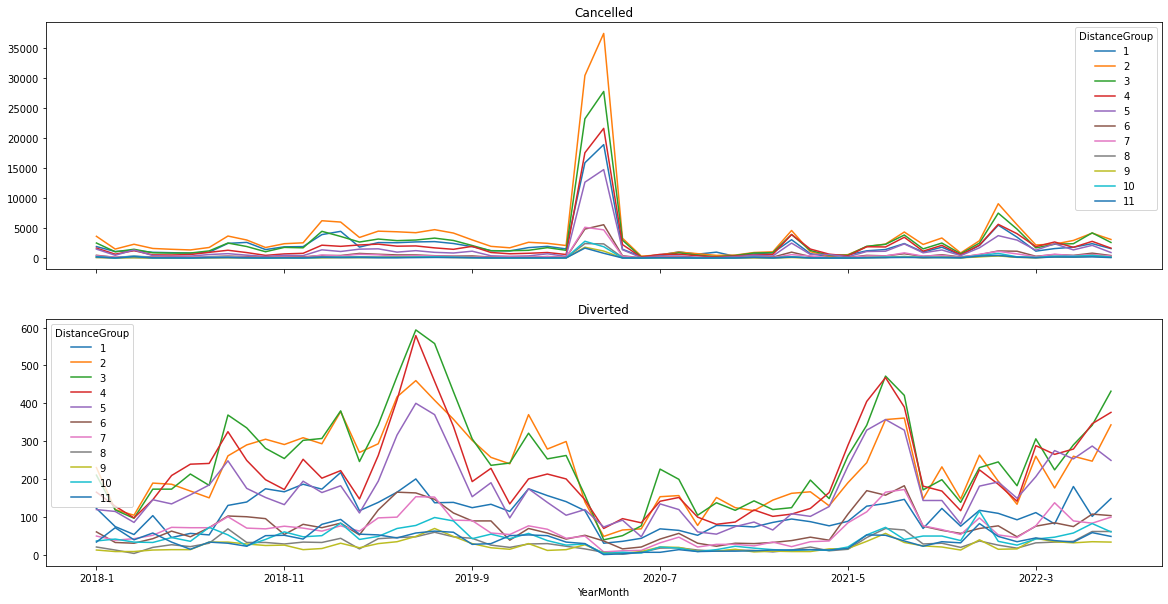

In [47]:
# Plot cancellations and Diverted by length of flight
g_main_df = main_df.groupby(["Year","Month","DistanceGroup"]).sum().unstack().reset_index()
g_main_df["YearMonth"] = g_main_df["Year"].astype(str)+"-"+g_main_df["Month"].astype(str)

subplots = 2
fig, ax = plt.subplots(subplots,1,figsize = (20,10))
prediction_cols = ["Cancelled","Diverted"]
for i in range(subplots):
    g_main_df[[prediction_cols[i],"YearMonth"]].plot(x="YearMonth",y=prediction_cols[i],kind = "line", legend = True,ax = ax[i],sharex = True,title = prediction_cols[i])

In [69]:
g_main_df = main_df.groupby(["OriginState"]).sum()

C:\Users\OliverSvaneOlsen\AppData\Local\Temp\ipykernel_19452\2568093492.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [71]:
# plot a choropleth with color range by count per state
fig = px.choropleth(g_main_df['Cancelled'].reset_index(),
                    locations='OriginState',
                    locationmode="USA-states",
                    scope="usa",
                    color="Cancelled",
                    color_continuous_scale="Oranges",
                   )
# center the title
fig.update_layout(title_text='Count of Cancelled flights by origin state', title_x=0.5)
fig.show()

In [73]:
state_df = g_main_df[['Cancelled','count']].reset_index()
state_df["ratio"] = state_df['Cancelled']/state_df['count']

# plot a choropleth with color range by count per state
fig = px.choropleth(state_df,
                    locations='OriginState',
                    locationmode="USA-states",
                    scope="usa",
                    color="ratio",
                    color_continuous_scale="Oranges",
                   )
# center the title
fig.update_layout(title_text='Ratio of Cancelled flights by origin state', title_x=0.5)
fig.show()